In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [2]:
%matplotlib inline

In [3]:
from matplotlib import rcParams
rcParams['figure.figsize'] = [16, 8]
# rcParams['font.family'] = ['sans-serif']
# rcParams['axes.unicode_minus'] = False

In [4]:
# from matplotlib.font_manager import _rebuild
# _rebuild()

In [5]:
training_set = pd.read_csv('airline-passengers.csv')
training_set = pd.read_csv('shampoo.csv')

training_set = training_set.iloc[:,1:2].values
training_set = training_set # / training_set.max() * 100

#####
n = 200
x = np.linspace(0, 100, n)
training_set = np.sin(x) + 1
training_set = training_set + np.cumsum(np.random.randn(n)) / np.sqrt(n)
training_set = training_set.reshape(n, 1)

#####
# training_set = np.cumsum(np.random.randn(n)) / np.sqrt(n)
training_set = np.cumsum(np.random.randn(n)) / np.log(n)
training_set = training_set.reshape(n, 1)

In [6]:
# plt.plot?

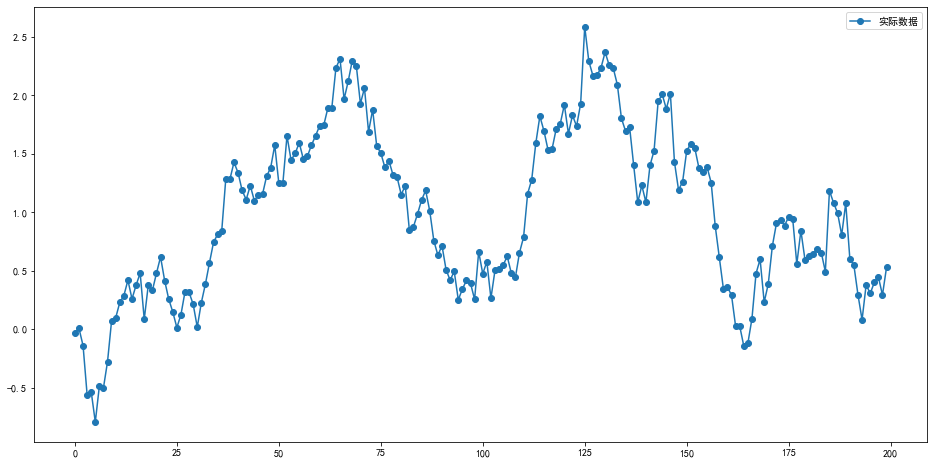

In [7]:
plt.plot(training_set, '-o', label = '实际数据')
plt.legend()

In [8]:
def sliding_windows(data, seq_length, pre_size):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length:i+seq_length+pre_size]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length, 1)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[:train_size])))
trainY = Variable(torch.Tensor(np.array(y[:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:])))
testY = Variable(torch.Tensor(np.array(y[train_size:])))

In [9]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [10]:

num_epochs = 3000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

/home/left5/venv3/lib/python3.6/site-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([130, 1, 1])) that is different to the input size (torch.Size([130, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, loss: 0.02553
Epoch: 100, loss: 0.02284
Epoch: 200, loss: 0.02284
Epoch: 300, loss: 0.02284
Epoch: 400, loss: 0.02284
Epoch: 500, loss: 0.02284
Epoch: 600, loss: 0.02284
Epoch: 700, loss: 0.02284
Epoch: 800, loss: 0.02284
Epoch: 900, loss: 0.02284
Epoch: 1000, loss: 0.02284
Epoch: 1100, loss: 0.02284
Epoch: 1200, loss: 0.02284
Epoch: 1300, loss: 0.02284
Epoch: 1400, loss: 0.02284
Epoch: 1500, loss: 0.02284
Epoch: 1600, loss: 0.02284
Epoch: 1700, loss: 0.02284
Epoch: 1800, loss: 0.02284
Epoch: 1900, loss: 0.02284
Epoch: 2000, loss: 0.02284
Epoch: 2100, loss: 0.02284
Epoch: 2200, loss: 0.02284
Epoch: 2300, loss: 0.02284
Epoch: 2400, loss: 0.02284
Epoch: 2500, loss: 0.02284
Epoch: 2600, loss: 0.02284
Epoch: 2700, loss: 0.02284
Epoch: 2800, loss: 0.02284
Epoch: 2900, loss: 0.02284


In [11]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot, label=u'真实数据')
plt.plot(data_predict, label=u'预测数据')
plt.suptitle('随机数序列预测')
plt.legend()
plt.show()

ValueError: Found array with dim 3. Estimator expected <= 2.

In [ ]:
lstm([])